In [306]:
from transformers import CLIPProcessor, CLIPModel
from transformers import GPT2Tokenizer, GPT2Model
import torch
from scipy.spatial.distance import euclidean
from itertools import product
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from pathlib import Path
from utils import *
from scipy.stats import pearsonr, spearmanr

In [307]:
def accuracy_all_sents(output, all_targets, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    all_corrects = []
    for i in range(all_targets.shape[1]): # nb of possible label for each image
        correct = pred.eq(all_targets[:,i].view(1, -1).expand_as(pred))
        all_corrects.append(correct)
    correct = torch.logical_or(*all_corrects)
    # remove duplicate for top>1
    correct = correct.cumsum(axis=0).cumsum(axis=0) == 1 
    return [correct[:k].reshape(-1).float().cpu().numpy() for k in topk]

In [308]:
def acc_maison(probs, labels, mean=True):
    if isinstance(labels, torch.Tensor):
        labels = labels.detach().numpy()
        lab = labels[:,0].tolist()
        lab_mirror = labels[:,1].tolist()
    probs = probs.detach().numpy()
    perf = []
    for label, prob in zip(labels, probs):
#         print(label, prob.shape, np.argmax(prob))
        if np.argmax(prob) in (lab.index(label[0]), lab_mirror.index(label[0])):
            perf.append(1)
        else:
            perf.append(0)
    return np.mean(perf) if mean else np.asarray(perf).astype(float)

In [309]:
model_name = "openai/clip-vit-base-patch32" #"flax-community/clip-rsicd-v2"
processor = CLIPProcessor.from_pretrained(model_name)
full_model = CLIPModel.from_pretrained(model_name)
text_model = full_model.text_model
sos, eos = 1, 1

# processor = GPT2Tokenizer.from_pretrained('gpt2-xl')
# processor.pad_token = processor.eos_token
# text_model = None
# text_model = GPT2Model.from_pretrained('gpt2-xl')
# sos, eos = 0, 0

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


In [310]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))

def euclidean_distance(x, y):   
    return np.sqrt(np.sum((x - y) ** 2))

def distance(a, b, mode='euclidean'):
    if mode == 'euclidean':
        return euclidean_distance(a, b)
    elif mode =='cosine':
        return -cosine_similarity(a, b)
    else:
        raise NotImplementedError
        
mode = "euclidean"
# mode = "cosine"

In [311]:
colors = ["red", "green", "blue", "yellow"] #, "purple"]
# colors = ["big", "small", "huge", "tiny", "red", "green", "blue", "yellow"]
shapes = ["square", "triangle", "circle", "star", "card", "ball", "book", "box"] 
# shapes = ["card", "ball", "book", "box"]

In [312]:
layers = np.arange(13)
dist_all_layers = []
for layer in layers:
    distances = []
    differences = [] # differences separately for each dim 
    for color, shape in product(colors, shapes):
        all_sentences = [color, shape, " ".join(["A", color, shape])]
        with torch.no_grad():
            inputs = processor(text=all_sentences, return_tensors="pt", padding=True, truncation=True)
            assert inputs.input_ids.shape[1] == 3 + sos + eos, f"{color}, {shape}, {inputs.input_ids.shape}"
            outputs = text_model(**inputs, output_hidden_states=True, return_dict=True)
        
        layer_emb = outputs.hidden_states[layer].numpy()
        sent_id = 0        # extract activations for words separately
        word_id = 0
        color_emb = layer_emb[sent_id][word_id+sos]
        sent_id = 1
        word_id = 0
        shape_emb = layer_emb[sent_id][word_id+sos]
        
        sent_id = 2        # extract activations for bound words
        word_id = 0
        color_hemb = layer_emb[sent_id][word_id+sos]
        sent_id = 2
        word_id = 1
        shape_hemb = layer_emb[sent_id][word_id+sos]

        d_independent = distance(color_emb, shape_emb, mode=mode)
        d_bound = distance(color_hemb, shape_hemb, mode=mode)
        distances.append(d_independent - d_bound)
        
        match = color_hemb - shape_hemb
        mismatch = color_emb - shape_emb
        differences.append(mismatch - match)
    dist_all_layers.append(np.mean(distances, 0))

Text(0, 0.5, 'euclidean distance')

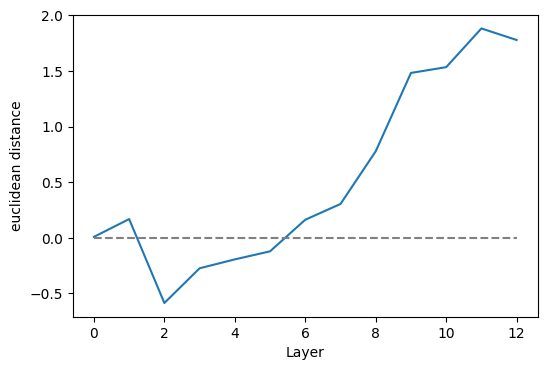

In [313]:
# print(processor.tokenizer.tokenize(all_sentences[1]))
# distances
plt.figure(dpi=100)
plt.plot(layers, dist_all_layers)
plt.plot(layers, np.zeros_like(layers), ls="--", c="grey")
plt.xlabel("Layer")
plt.ylabel(f"{mode} distance")

In [314]:
# plt.plot(np.mean(differences, 0))

In [341]:
## Get model performance on the image task and
## compute embeddings for all sentences
path = Path("/Users/tdesbordes/Documents/CLIP-analyze/stimuli/original_images/scene")
all_imgs_fns = os.listdir(path)
all_imgs = [Image.open(f"{path}/{fn}") for fn in all_imgs_fns]
all_imgs = [im.convert('RGB') for im in all_imgs]
img_labels = [s[0:-4].lower() for s in all_imgs_fns]
# img_labels = [s.replace("to the", "is").replace("of", "to") for s in img_labels]
img_labels = [s.replace("to the left of", "is left to").replace("to the right of", "is right to") for s in img_labels]
separator = " is X to "
# separator = " to the X of "

# get all correct labels for each image: the "classic" one and the one resulting from inversing the relation (left/right)
all_labels = []
print(img_labels[0])
for i, cap in enumerate(img_labels):
    all_labels.append([i])
    mirror_sent = get_inverse_sentence(cap, separator)
    for idx in [i for i, x in enumerate(img_labels) if x == mirror_sent]:
        all_labels[-1].append(idx)
all_labels = torch.tensor(all_labels)
# print(all_labels.shape)

with torch.no_grad():
    inputs = processor(text=img_labels, images=all_imgs, return_tensors="pt", padding=True)
assert inputs.input_ids.shape[1] == 9 + sos + eos, inputs.input_ids.shape # 9 tokens + 2 flanking special tokens
all_outputs = full_model(**inputs, output_hidden_states=True, return_dict=True)

a green triangle is left to a blue square


In [342]:
logits = all_outputs.logits_per_image
probs = logits.softmax(0) #.softmax(1)
accs = accuracy(probs, all_labels, topk=(1, 2, 5,))
print(accs)

[66.0, 116.0, 146.0]


In [343]:
print(all_outputs.keys())
# print(all_outputs.logits_per_image.shape, all_labels.shape)
print(probs.shape, torch.tensor(all_labels).shape)
# accs = accuracy(all_outputs.logits_per_image, all_labels, topk=(1, 2, 5,))
topk = (1, 3, 5,)
accs = accuracy(probs, all_labels, topk=topk)
print([f"top{k} acc = {a/len(all_labels):.3f}" for a, k in zip(accs, topk)])
accs = acc_maison(probs, all_labels)
print(accs)
accs_all_sents = acc_maison(probs, all_labels, mean=False)
# accs_all_sents = accuracy_all_sents(probs.t(), all_labels, topk=(1,))[0]
# accs_all_sents == accs_all_sents2
# # shape (n_sents*topk) ! should not be used for topk != 1 and only for len(topk)=1
# print(accs_all_sents.sum(), accs_all_sents.sum() / len(accs_all_sents))
# print(accs_all_sents)
# accs_all_sents

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
torch.Size([162, 162]) torch.Size([162, 2])
['top1 acc = 0.407', 'top3 acc = 0.778', 'top5 acc = 0.901']
0.4074074074074074


/Users/tdesbordes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [344]:
text_outputs = torch.stack(all_outputs.text_model_output.hidden_states)
text_outputs = text_outputs.transpose(1,0).detach().numpy() # n_sents * n_layers * n_tokens * n_units
text_outputs.shape

(162, 13, 11, 512)

Layer:  0, correlation of perf with distance:  0.125, pval=0.1142     and  0.103, pval=0.1903    
Layer:  1, correlation of perf with distance: -0.025, pval=0.7498     and  0.094, pval=0.2318    
Layer:  2, correlation of perf with distance:  0.028, pval=0.7216     and  0.149, pval=0.0578    
Layer:  3, correlation of perf with distance:  0.158, pval=0.0452 *   and  0.132, pval=0.0932    
Layer:  4, correlation of perf with distance:  0.175, pval=0.0259 *   and  0.109, pval=0.1688    
Layer:  5, correlation of perf with distance:  0.081, pval=0.3061     and  0.029, pval=0.7182    
Layer:  6, correlation of perf with distance:  0.010, pval=0.8992     and  0.010, pval=0.8978    
Layer:  7, correlation of perf with distance: -0.013, pval=0.8697     and -0.005, pval=0.9518    
Layer:  8, correlation of perf with distance: -0.031, pval=0.6972     and  0.018, pval=0.8240    
Layer:  9, correlation of perf with distance:  0.013, pval=0.8707     and -0.023, pval=0.7750    
Layer: 10, correlati

Text(0, 0.5, 'Difference between mismatch and match')

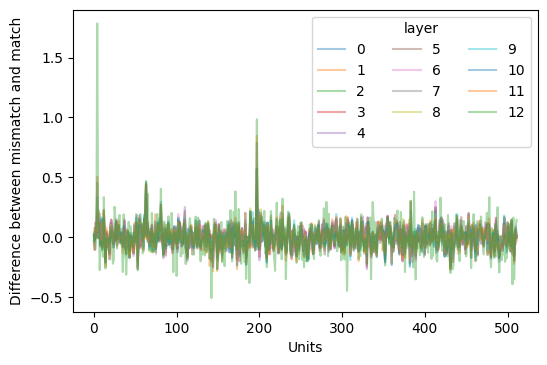

In [345]:
# MEG experiment-like sentences
verbose = False

sent_id = 0
dist_all_layers = []
dist_all_layers2 = []
all_differences = []
layers = np.arange(13)
plt.figure(dpi=100)
for layer in layers:
    distances1 = [] # euclidean distances between first shape and both colors
    distances2 = [] # euclidean distances between second shape and both colors
    differences = [] # differences separately for each dim 

    for i_sent, outputs in enumerate(text_outputs): # loop over sentences
        if verbose: 
            tokens = processor.tokenizer.tokenize(img_labels[i_sent])
            print(tokens, len(tokens))
        layer_emb = outputs[layer] # n_tokens * n_units
        word_id = 1        # extract activations for color1
        if verbose: print(tokens[word_id])
        color1_emb = layer_emb[word_id+sos]
        word_id = 7        # extract activations for color2
        if verbose: print(tokens[word_id])
        color2_emb = layer_emb[word_id+sos]
        word_id = 2        # extract activations for shape1
        if verbose: print(tokens[word_id])
        shape1_emb = layer_emb[word_id+sos]
        word_id = 8        # extract activations for shape2
        if verbose: print(tokens[word_id])
        shape2_emb = layer_emb[word_id+sos]

        d_match = distance(color1_emb, shape1_emb, mode=mode)
        d_mismatch = distance(color2_emb, shape1_emb, mode=mode)
        distances1.append(d_mismatch - d_match)

        d_match = distance(color2_emb, shape2_emb, mode=mode)
        d_mismatch = distance(color1_emb, shape2_emb, mode=mode)
        distances2.append(d_mismatch - d_match)

        match = color1_emb - shape1_emb
        mismatch = color2_emb - shape1_emb
        differences.append(mismatch - match)

    dist_all_layers.append(np.mean(distances1, 0))
    dist_all_layers2.append(np.mean(distances2, 0))
    all_differences.append(differences)
    
    # correlation with performance
    r1, p1 = pearsonr(accs_all_sents, distances1)
    r2, p2 = pearsonr(accs_all_sents, distances2)
    s1 = '***' if  p1<0.001 else '** ' if p1<0.005 else '*  ' if p1<0.05 else '   '
    s2 = '***' if  p2<0.001 else '** ' if p2<0.005 else '*  ' if p2<0.05 else '   '
    print(f"Layer: {layer:2}, correlation of perf with distance: {r1:6.3f}, pval={p1:5.4f} {s1} and {r2:6.3f}, pval={p2:5.4f} {s2}")
    
    plt.plot(np.mean(differences, 0), alpha=.4, label=layer)
plt.legend(ncol=3, title="layer")
plt.xlabel("Units")
plt.ylabel("Difference between mismatch and match")

0.041116804 1.7154844


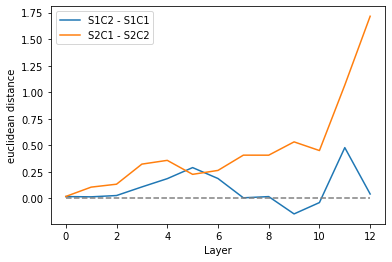

In [346]:
print(np.mean(distances1), np.mean(distances2))
plt.plot(layers, dist_all_layers, label="S1C2 - S1C1")
plt.plot(layers, dist_all_layers2, label="S2C1 - S2C2")
plt.plot(layers, np.zeros_like(layers), ls="--", c="grey")
plt.xlabel("Layer")
plt.ylabel(f"{mode} distance")
plt.legend()

In [347]:
## look at dimension that has the highest distance for joint vs disjoint
for layer in layers:
    best_unit = np.argsort(np.mean(all_differences[layer], 0))[-1]

# for each sentences, get the current layer, last token activation of the best unit
    best_unit_activations = [out[layer, -1, best_unit] for out in text_outputs]
    r, p = pearsonr(best_unit_activations, accs_all_sents)
    s = '***' if  p<0.001 else '** ' if p<0.005 else '*  ' if p<0.05 else '   '
    print(f"Layer {layer:2}, unit={best_unit:3}, r={r:5.3f}, pval={p:6.4f} {s}")

Layer  0, unit=132, r=  nan, pval=   nan    
Layer  1, unit=197, r=-0.179, pval=0.0230 *  
Layer  2, unit= 63, r=-0.011, pval=0.8860    
Layer  3, unit= 63, r=-0.168, pval=0.0326 *  
Layer  4, unit= 63, r=-0.201, pval=0.0102 *  
Layer  5, unit= 63, r=-0.221, pval=0.0048 ** 
Layer  6, unit=197, r=-0.251, pval=0.0013 ** 
Layer  7, unit=197, r=-0.287, pval=0.0002 ***
Layer  8, unit=197, r=-0.264, pval=0.0007 ***
Layer  9, unit=197, r=-0.160, pval=0.0420 *  
Layer 10, unit=197, r=-0.227, pval=0.0036 ** 
Layer 11, unit=197, r=-0.137, pval=0.0828    
Layer 12, unit=  4, r=-0.094, pval=0.2341    


/Users/tdesbordes/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [348]:
def get_inverse_sentence_long_range(sentence, sep):
    # gets the mirror image sentence
    if "X" in sep: sep = sep.replace("X", "right") if "right" in sentence else sep.replace("X", "left")
    first_color = sentence.split(" ")[-1]
    second_color = sentence.split(" ")[-4]
    first_shape = sentence.split(" ")[1]
    second_shape = sentence.split(" ")[-3]
#     print(first_color, first_shape, second_color, second_shape)
    mirror_sent = f"The {second_shape}{sep}the {first_color} {first_shape} is {second_color}"
    if "right" in sentence:
        mirror_sent = mirror_sent.replace("right", "left")
    elif "left" in sentence:
        mirror_sent = mirror_sent.replace("left", "right")
    else:
        raise RuntimeError
    return mirror_sent

In [349]:
## Get model performance on the image task with longe-range sentences and
## compute embeddings for all sentences
path = Path("/Users/tdesbordes/Documents/CLIP-analyze/stimuli/original_images/scene")
all_imgs_fns = os.listdir(path)
all_imgs = [Image.open(f"{path}/{fn}") for fn in all_imgs_fns]
all_imgs = [im.convert('RGB') for im in all_imgs]
img_labels = [s[0:-4].lower() for s in all_imgs_fns]
new_sents = [" ".join([f"The"] + s.split()[2::] + [f"is {s.split()[1]}"]) for s in img_labels]
new_sents = [s.replace(" a ", " the ") for s in new_sents]
separator = " to the X of "
# get all correct labels for each image: the "classic" one and the one resulting from inversing the relation (left/right)
all_labels = []
for i, cap in enumerate(new_sents):
    all_labels.append([i])
    mirror_sent = get_inverse_sentence_long_range(cap, separator)
    for idx in [i for i, x in enumerate(new_sents) if x == mirror_sent]:
        all_labels[-1].append(idx)
all_labels = torch.tensor(all_labels)

with torch.no_grad():
    inputs = processor(text=new_sents, images=all_imgs, return_tensors="pt", padding=True)
assert inputs.input_ids.shape[1] == 11 + sos + eos, inputs.input_ids.shape # 9 tokens + 2 flanking special tokens
all_outputs = full_model(**inputs, output_hidden_states=True, return_dict=True)

In [350]:
logits = all_outputs.logits_per_image
probs = logits.softmax(0)
accs = accuracy(probs, all_labels, topk=(1, 2, 5,))
print(accs)

[54.0, 94.0, 142.0]


In [351]:
topk = (1, 3, 5,)
accs = accuracy(probs, all_labels, topk=topk)
print([f"top{k} acc = {a/len(all_labels):.3f}" for a, k in zip(accs, topk)])
accs = acc_maison(probs, all_labels)
# print(accs)
accs_all_sents = acc_maison(probs, all_labels, mean=False)
# accs_all_sents = accuracy_all_sents(probs.t(), all_labels, topk=(1,))[0]
# accs_all_sents == accs_all_sents2
# # shape (n_sents*topk) ! should not be used for topk != 1 and only for len(topk)=1

['top1 acc = 0.333', 'top3 acc = 0.728', 'top5 acc = 0.877']


In [352]:
text_outputs = torch.stack(all_outputs.text_model_output.hidden_states)
text_outputs = text_outputs.transpose(1,0).detach().numpy() # n_sents * n_layers * n_tokens * n_units
# text_outputs.shape

Layer:  0, correlation of perf with distance: -0.020, pval=0.8033     and  0.044, pval=0.5794    
Layer:  1, correlation of perf with distance: -0.011, pval=0.8914     and  0.011, pval=0.8914    
Layer:  2, correlation of perf with distance: -0.014, pval=0.8552     and  0.021, pval=0.7873    
Layer:  3, correlation of perf with distance: -0.007, pval=0.9295     and -0.028, pval=0.7228    
Layer:  4, correlation of perf with distance:  0.007, pval=0.9316     and  0.001, pval=0.9881    
Layer:  5, correlation of perf with distance:  0.022, pval=0.7781     and  0.047, pval=0.5513    
Layer:  6, correlation of perf with distance:  0.062, pval=0.4336     and  0.019, pval=0.8112    
Layer:  7, correlation of perf with distance:  0.052, pval=0.5077     and  0.022, pval=0.7807    
Layer:  8, correlation of perf with distance:  0.030, pval=0.7062     and  0.029, pval=0.7167    
Layer:  9, correlation of perf with distance:  0.003, pval=0.9723     and  0.068, pval=0.3913    
Layer: 10, correlati

Text(0, 0.5, 'Difference between mismatch and match')

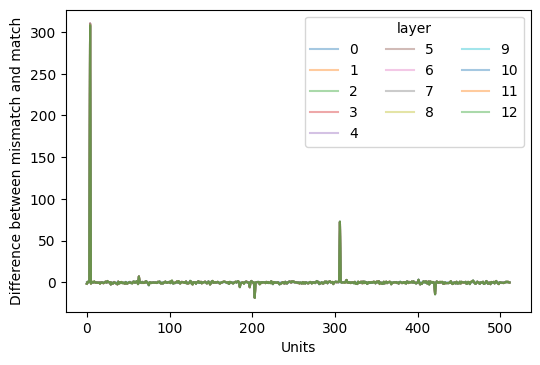

In [360]:
# MEG experiment-like sentences
verbose = False

sent_id = 0
dist_all_layers = []
dist_all_layers2 = []
all_differences = []
layers = np.arange(13)
plt.figure(dpi=100)
for layer in layers:
    distances1 = [] # euclidean distances between first shape and both colors
    distances2 = [] # euclidean distances between second shape and both colors
    differences = [] # differences separately for each dim 
    for i_sent, outputs in enumerate(text_outputs): # loop over sentences
        if verbose: 
            tokens = processor.tokenizer.tokenize(new_sents[i_sent])
            print(tokens, len(tokens))
        layer_emb = outputs[layer] # n_tokens * n_units
        word_id = -1        # extract activations for color1
        if verbose: print(tokens[word_id])
        color1_emb = layer_emb[word_id+sos]
        word_id = 7        # extract activations for color2
        if verbose: print(tokens[word_id])
        color2_emb = layer_emb[word_id+sos]
        word_id = 1        # extract activations for shape1
        if verbose: print(tokens[word_id])
        shape1_emb = layer_emb[word_id+sos]
        word_id = 8        # extract activations for shape2
        if verbose: print(tokens[word_id])
        shape2_emb = layer_emb[word_id+sos]

        d_match = distance(color1_emb, shape1_emb, mode=mode)
        d_mismatch = distance(color2_emb, shape1_emb, mode=mode)
        distances1.append(d_mismatch - d_match)

        d_match = distance(color2_emb, shape2_emb, mode=mode)
        d_mismatch = distance(color1_emb, shape2_emb, mode=mode)
        distances2.append(d_mismatch - d_match)

        match = color1_emb - shape1_emb
        mismatch = color2_emb - shape1_emb
        differences.append(mismatch - match)

    dist_all_layers.append(np.mean(distances1, 0))
    dist_all_layers2.append(np.mean(distances2, 0))
    all_differences.append(differences)
    
    # correlation with performance
    r1, p1 = pearsonr(accs_all_sents, distances1)
    r2, p2 = pearsonr(accs_all_sents, distances2)
    s1 = '***' if  p1<0.001 else '** ' if p1<0.005 else '*  ' if p1<0.05 else '   '
    s2 = '***' if  p2<0.001 else '** ' if p2<0.005 else '*  ' if p2<0.05 else '   '
    print(f"Layer: {layer:2}, correlation of perf with distance: {r1:6.3f}, pval={p1:5.4f} {s1} and {r2:6.3f}, pval={p2:5.4f} {s2}")
    
    plt.plot(np.mean(differences, 0), alpha=.4, label=layer)
plt.legend(ncol=3, title="layer")
plt.xlabel("Units")
plt.ylabel("Difference between mismatch and match")

-304.48315 307.1655


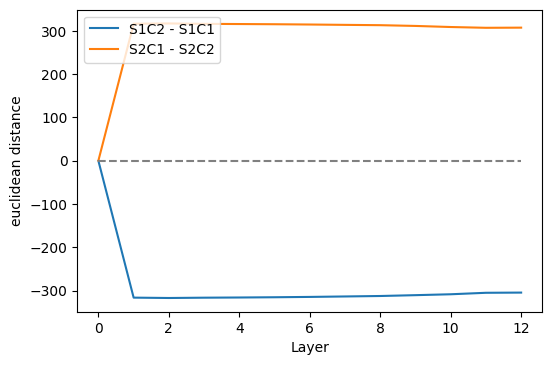

In [354]:
print(np.mean(distances1), np.mean(distances2))
plt.figure(dpi=100)
plt.plot(layers, dist_all_layers, label="S1C2 - S1C1")
plt.plot(layers, dist_all_layers2, label="S2C1 - S2C2")
plt.plot(layers, np.zeros_like(layers), ls="--", c="grey")
plt.xlabel("Layer")
plt.ylabel(f"{mode} distance")
plt.legend()

Layer  0, unit=132, r=   nan, pval=   nan    
Layer  1, unit=  4, r= 0.195, pval=0.0131 *  
Layer  2, unit=  4, r= 0.301, pval=0.0001 ***
Layer  3, unit=  4, r= 0.115, pval=0.1442    
Layer  4, unit=  4, r= 0.105, pval=0.1836    
Layer  5, unit=  4, r= 0.041, pval=0.6084    
Layer  6, unit=  4, r=-0.063, pval=0.4260    
Layer  7, unit=  4, r=-0.159, pval=0.0435 *  
Layer  8, unit=  4, r=-0.188, pval=0.0164 *  
Layer  9, unit=  4, r=-0.163, pval=0.0378 *  
Layer 10, unit=  4, r=-0.192, pval=0.0143 *  
Layer 11, unit=  4, r=-0.166, pval=0.0343 *  
Layer 12, unit=  4, r=-0.211, pval=0.0071 *  


/Users/tdesbordes/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0, 0.5, 'correlation of the 4th unit with performance')

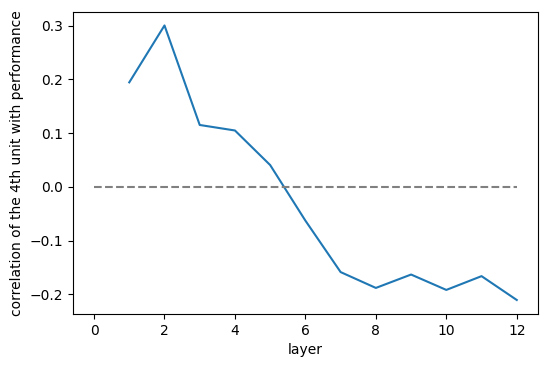

In [355]:
## look at dimension that has the highest distance for joint vs disjoint
all_r = []
for layer in layers:
    best_unit = np.argsort(np.mean(all_differences[layer], 0))[-1]
    # for each sentences, get the current layer, last token activation of the best unit
    best_unit_activations = [out[layer, -1, best_unit] for out in text_outputs]
    r, p = pearsonr(best_unit_activations, accs_all_sents)
    s = '***' if  p<0.001 else '** ' if p<0.005 else '*  ' if p<0.05 else '   '
    print(f"Layer {layer:2}, unit={best_unit:3}, r={r:6.3f}, pval={p:6.4f} {s}")
    all_r.append(r)

plt.figure(dpi=100)
plt.plot(layers, all_r)
plt.plot(layers, np.zeros_like(layers), ls="--", c="grey")
plt.xlabel("layer")
plt.ylabel("correlation of the 4th unit with performance")

In [356]:
# # Long-range embedding sentences
# verbose = False
# mode = "cosine"

# ## Compute all embeddings
# all_outputs = []
# for color1, shape1, color2, shape2 in product(colors, shapes, colors, shapes):
#     all_sentences = [f"The {shape1} to the left of the {color2} {shape2} is {color1}"]    
#     with torch.no_grad():
#         inputs = processor(text=all_sentences, return_tensors="pt", padding=True)
#         assert inputs.input_ids.shape[1] == 11 + sos + eos # 11 tokens + 2 flanking special tokens
#         outputs = model(**inputs, output_hidden_states=True, return_dict=True)
#         all_outputs.append(np.stack(outputs.hidden_states))
# #         tokens = processor.tokenizer.tokenize(all_sentences[0])
# #         if verbose: print(tokens, len(tokens))
# sent_id = 0
# dist_all_layers = []
# dist_all_layers2 = []
# layers = np.arange(13)
# for layer in layers:
#     distances = []
#     distances2 = []
#     differences = []

#     for outputs in all_outputs:
#         layer_emb = outputs[layer]
# #         layer_emb = outputs.hidden_states[layer].numpy() 
#         # extract activations for color1
#         word_id = 10
#         if verbose: print(tokens[word_id])
#         color1_emb = layer_emb[sent_id][word_id+sos]
#         # extract activations for color2
#         word_id = 7
#         if verbose: print(tokens[word_id])
#         color2_emb = layer_emb[sent_id][word_id+sos]
#         # extract activations for shape1
#         word_id = 1
#         if verbose: print(tokens[word_id])
#         shape1_emb = layer_emb[sent_id][word_id+sos]
#         # extract activations for shape2
#         word_id = 8
#         if verbose: print(tokens[word_id])
#         shape2_emb = layer_emb[sent_id][word_id+sos]

#         d_match = distance(color1_emb, shape1_emb, mode=mode)
#         d_mismatch = distance(color2_emb, shape1_emb, mode=mode)
#         distances.append(d_mismatch - d_match)

#         d_match = distance(color2_emb, shape2_emb, mode=mode)
#         d_mismatch = distance(color1_emb, shape2_emb, mode=mode)
#         distances2.append(d_mismatch - d_match)

#         match = color1_emb - shape1_emb
#         mismatch = color2_emb - shape1_emb
#         differences.append(mismatch - match)

#     dist_all_layers.append(np.mean(distances, 0))
#     dist_all_layers2.append(np.mean(distances2, 0))

In [357]:
# print(np.mean(distances), np.mean(distances2))
# plt.plot(layers, dist_all_layers, label="S1C2 - S1C1")
# plt.plot(layers, dist_all_layers2, label="S2C1 - S2C2")
# plt.plot(layers, np.zeros_like(layers), ls="--", c="grey")
# plt.xlabel("Layer")
# plt.ylabel("Euclidean distance")
# plt.legend()

In [358]:
# plt.plot(np.mean(differences, 0))